# Introduction to Synthetic Data Generation for Tabular Data


References: 

[1] [SDV: An Open Source Library for Synthetic Data Generation](https://dai.lids.mit.edu/wp-content/uploads/2018/12/Andrew_MEng.pdf)
M.Eng Thesis, Dept. of EECS, MIT, August 2018, Andrew Montanez

[2] A. Janosi, W. Steinbrunn, M. Pfisterer, and R. Detrano. "Heart Disease," UCI Machine Learning Repository, 1989. [Online]. Available: https://doi.org/10.24432/C52P4X.

---

## Introduction

Synthetic data generation allows us to create *artificial data* that mimics the
statistical properties of real datasets. The goal is to preserve *utility* (patterns,
relationships, distributions) while enabling safe sharing and experimentation.

In this tutorial, we will:

1. Load a real-world dataset (Heart Disease dataset from the UCI repository).
2. Use the **SDV (Synthetic Data Vault)** library to fit a synthesizer.
3. Generate synthetic samples.
4. Compare real vs. synthetic data using:
   - **Visual distributions**
   - **Summary statistics**
   - **Information-theoretic metrics** (Jensen–Shannon Divergence)
   - **Utility test** (Train-on-Synthetic, Test-on-Real)


In [ ]:
# Install dependencies
!pip install numpy pandas matplotlib sdv ucimlrepo seaborn scipy

---

### Loading the Dataset

We begin with the **UCI Heart Disease dataset** [2].
From this dataset, we sample 100 rows to use as our "real" subset. This keeps
the workflow light, while still demonstrating the full pipeline.

### Heart Disease Dataset: Feature Definitions

We use a subset of the **UCI Heart Disease dataset** (Cleveland version).  
Below are the definitions of the features we work with later in this notebook:

| Feature    | Description |
|------------|-------------|
| **age**    | Age of the patient (years). |
| sex        | Biological sex (1 = male, 0 = female). |
| cp         | Chest pain type: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic. |
| **trestbps** | Resting blood pressure (mm Hg) when admitted. |
| **chol**   | Serum cholesterol level (mg/dl). |
| fbs        | Fasting blood sugar > 120 mg/dl (1 = true, 0 = false). |
| restecg    | Resting electrocardiographic results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy. |
| **thalach** | Maximum heart rate achieved during exercise. |
| exang      | Exercise-induced angina (1 = yes, 0 = no). |
| oldpeak    | ST depression induced by exercise relative to rest. |
| slope      | Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping. |
| ca         | Number of major vessels (0–3) colored by fluoroscopy. |
| thal       | Thalassemia blood disorder test result: 3 = normal, 6 = fixed defect, 7 = reversible defect. |
| num        | Diagnosis of heart disease  |



### Features used in this notebook
- **age**, **trestbps**, **chol**, **thalach**: used in distribution comparisons and summary statistics.  

In [ ]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np


# Load dataset from UCI ML repository
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.features

# Number of samples to sample from the real heart disease dataset
NUM_HEART_DISEASE_SAMPLES = 100

# Random seed for reproducibility
np.random.seed(42)

# Sample from the real heart disease dataset
heart_disease_sampled_df = df.sample(n=NUM_HEART_DISEASE_SAMPLES, random_state=42).reset_index(drop=True)

heart_disease_sampled_df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,53,1,3,130,246,1,2,173,0,0.0,1,3.0,3.0
1,54,1,4,110,206,0,2,108,1,0.0,2,1.0,3.0
2,56,1,4,125,249,1,2,144,1,1.2,2,1.0,3.0
3,58,1,4,100,234,0,0,156,0,0.1,1,1.0,7.0
4,51,0,4,130,305,0,0,142,1,1.2,2,0.0,7.0


---

### Gaussian Copula in SDV

A **copula** is a mathematical tool that allows us to model the **dependence structure** between random variables separately from their individual (marginal) distributions.

The **Gaussian Copula** (used by default in SDV’s `GaussianCopulaSynthesizer` [1] ) works as follows:

1. Suppose our dataset has $n$ columns (features):  
   $X = (X_1, X_2, \dots, X_n)$

2. For each feature $X_i$, estimate its **marginal distribution** and compute its cumulative distribution function (CDF) $F_i(x)$.

3. Transform each value $x_i$ into a standard normal space using the **inverse Gaussian CDF** $\Phi^{-1}$:
   $$
   z_i = \Phi^{-1}(F_i(x_i))
   $$
   where $\Phi$ is the CDF of the standard normal distribution.

   This maps each feature into a space where marginals are standard normal, but correlations remain.

4. Fit a **multivariate Gaussian distribution** to the transformed data:
   $$
   Z = (z_1, z_2, \dots, z_n) \sim \mathcal{N}(0, \Sigma)
   $$
   where $\Sigma$ is the covariance matrix capturing dependencies.

5. To **generate synthetic samples**:
   - Sample $z = (z_1, \dots, z_n)$ from the fitted multivariate Gaussian.
   - Transform back to the original space:
     $$
     x_i = F_i^{-1}(\Phi(z_i))
     $$


**Intuition**:  
- Each column keeps its original distribution shape ($F_i$).  
- The Gaussian copula ensures that the **joint dependencies** between columns are preserved.  
- This lets SDV generate realistic synthetic rows that mimic both marginal distributions and correlations.


In [ ]:
# Import the GaussianCopulaSynthesizer and Metadata classes from the Synthetic Data Vault library
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata

# Number of samples to generate from the synthetic heart disease dataset
NUM_HEART_DISEASE_SYNTHETIC_SAMPLES = 50

# Detect metadata from the sampled heart disease dataset    
heart_disease_metadata = Metadata.detect_from_dataframe(heart_disease_sampled_df)

# Initialize the GaussianCopulaSynthesizer with the detected metadata
synthesizer = GaussianCopulaSynthesizer(heart_disease_metadata)

# Fit the synthesizer on the sampled heart disease dataset
synthesizer.fit(heart_disease_sampled_df)

# Generate a synthetic heart disease dataset
heart_disease_synthetic_data = synthesizer.sample(num_rows=NUM_HEART_DISEASE_SYNTHETIC_SAMPLES)

print(heart_disease_metadata)
heart_disease_synthetic_data.head()



/home/brand-ism/repos/synthetic-data-evaluation/env/lib/python3.12/site-packages/sdv/single_table/base.py:133: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



{
    "tables": {
        "table": {
            "columns": {
                "age": {
                    "sdtype": "numerical"
                },
                "sex": {
                    "sdtype": "categorical"
                },
                "cp": {
                    "sdtype": "categorical"
                },
                "trestbps": {
                    "sdtype": "numerical"
                },
                "chol": {
                    "sdtype": "numerical"
                },
                "fbs": {
                    "sdtype": "categorical"
                },
                "restecg": {
                    "sdtype": "categorical"
                },
                "thalach": {
                    "sdtype": "numerical"
                },
                "exang": {
                    "sdtype": "categorical"
                },
                "oldpeak": {
                    "sdtype": "numerical"
                },
                "slope": {
                    "s

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,4,133,229,0,0,142,1,0.2,2,0.0,7.0
1,37,1,4,134,256,0,0,133,0,0.6,2,1.0,7.0
2,39,1,4,108,227,0,0,174,0,0.0,2,0.0,3.0
3,53,0,4,122,296,0,2,163,0,0.7,2,0.0,7.0
4,51,1,3,151,331,0,2,143,0,1.0,1,3.0,3.0


---

### Distribution Comparison

We visualize distributions of selected features (`age`, `trestbps`, `chol`,
`thalach`) for both real and synthetic datasets.

- Similar *shapes* between the two histograms indicate that the synthesizer has
successfully learned the marginal distribution.
- Large differences would suggest underfitting or loss of information.


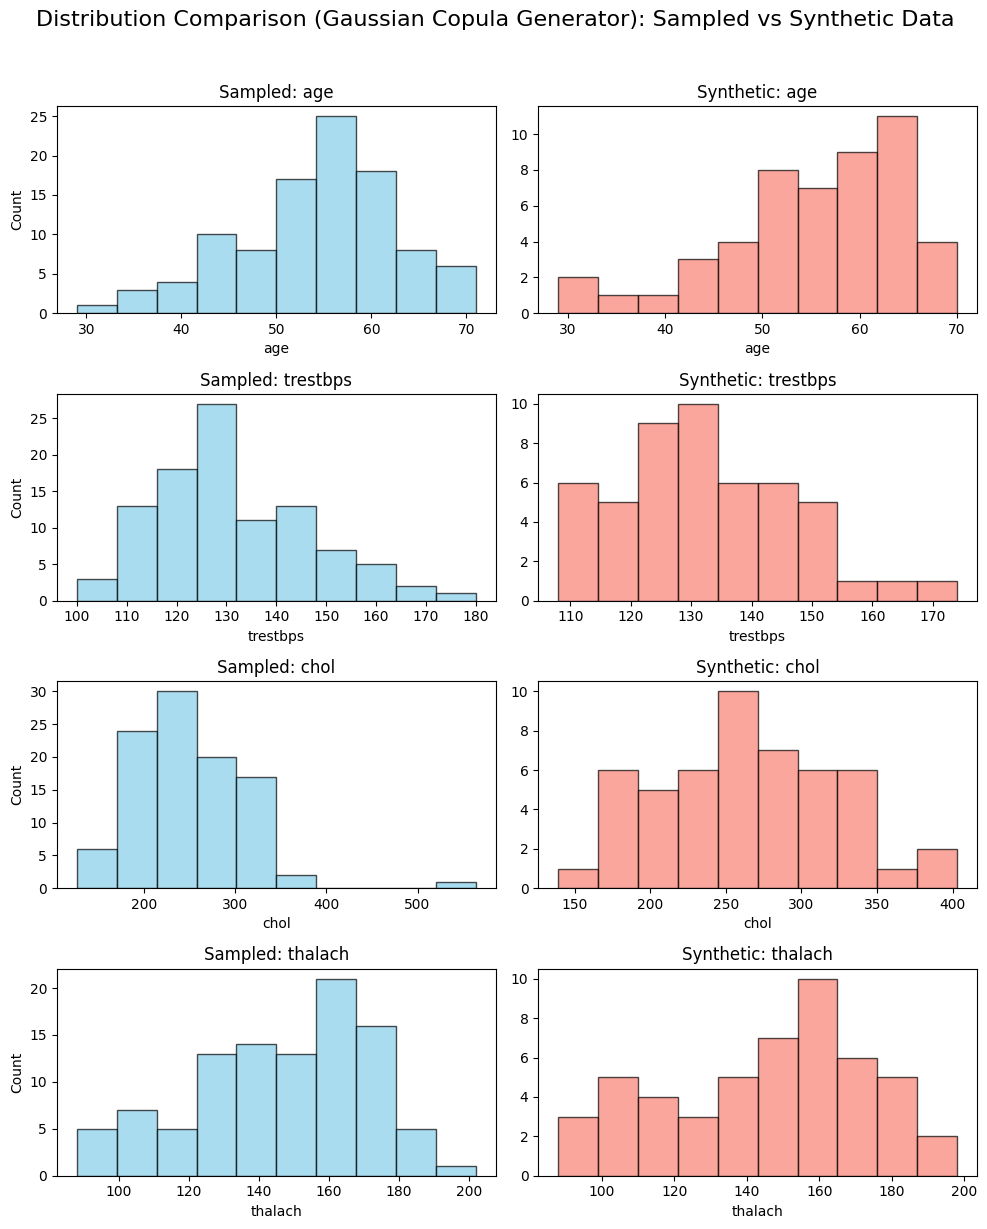

In [15]:
import matplotlib.pyplot as plt

# Select a few columns to compare
columns_to_compare = ['age', 'trestbps', 'chol', 'thalach']

# Create a figure with subplots for sampled and synthetic data
fig, axes = plt.subplots(len(columns_to_compare), 2, figsize=(10, 3 * len(columns_to_compare)))

# Set the title for the entire figure
fig.suptitle('Distribution Comparison (Gaussian Copula Generator): Sampled vs Synthetic Data', fontsize=16, y=1.02)

for i, col in enumerate(columns_to_compare):
    # Plot for sampled data
    axes[i, 0].hist(heart_disease_sampled_df[col], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'Sampled: {col}')
    axes[i, 0].set_ylabel('Count')
    
    # Plot for synthetic data
    axes[i, 1].hist(heart_disease_synthetic_data[col], bins=10, color='salmon', edgecolor='black', alpha=0.7)
    axes[i, 1].set_title(f'Synthetic: {col}')
    
    # Set x-labels
    axes[i, 0].set_xlabel(col)
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()


---


### Summary Statistics

As a first quantitative check, we compare:

- **Means**: does the central tendency match?
- **Standard deviations**: does the variability match?

Synthetic data should be close, though not identical, to real data.


In [5]:
# Compare summary statistics
summary_real = heart_disease_sampled_df[columns_to_compare].describe().T
summary_synth = heart_disease_synthetic_data[columns_to_compare].describe().T

summary_comparison = summary_real[['mean', 'std']].copy()
summary_comparison.columns = ['real_mean', 'real_std']
summary_comparison['synth_mean'] = summary_synth['mean']
summary_comparison['synth_std'] = summary_synth['std']

summary_comparison


,real_mean,real_std,synth_mean,synth_std
age,54.50,8.717219,55.26,9.224656
trestbps,130.46,15.361253,133.20,14.221283
chol,248.91,60.072027,264.20,60.336472
thalach,146.90,24.714736,144.68,27.710191


---

### Jensen–Shannon Divergence (JSD)

The **Jensen–Shannon divergence** is a symmetric and smoothed version of the Kullback–Leibler (KL) divergence.  
It measures how different two probability distributions are.

Given two discrete probability distributions $P$ and $Q$ over the same domain:

1. Define the **average distribution**:
$$
M = \frac{1}{2}(P + Q)
$$

2. The **JSD** is computed as:
$$
\mathrm{JSD}(P \parallel Q) = \frac{1}{2} D_{\mathrm{KL}}(P \parallel M) + \frac{1}{2} D_{\mathrm{KL}}(Q \parallel M)
$$

Where the **Kullback–Leibler divergence** is:
$$
D_{\mathrm{KL}}(P \parallel Q) = \sum_i P(i) \log \left( \frac{P(i)}{Q(i)} \right)
$$


### Properties:
- Symmetric: $\mathrm{JSD}(P \parallel Q) = \mathrm{JSD}(Q \parallel P)$  
- Always finite: $0 \leq \mathrm{JSD}(P \parallel Q) \leq \log 2$  
- Square root is a **metric**: $\sqrt{\mathrm{JSD}}$ satisfies the triangle inequality

- **Low JSD**: real and synthetic distributions are similar.
- **High JSD**: the synthesizer is failing to capture the real distribution.



In [6]:
from scipy.stats import entropy

def js_divergence(p, q, bins=10):
    """Compute JS divergence between two distributions"""
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)

    p_hist = p_hist + 1e-12  # avoid log(0)
    q_hist = q_hist + 1e-12

    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()
    m = 0.5 * (p_hist + q_hist)

    return 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))

# Calculate JS divergence for each column
js_scores = {
    col: js_divergence(heart_disease_sampled_df[col], heart_disease_synthetic_data[col])
    for col in columns_to_compare
}

print("Jensen-Shannon Divergence (lower is better):")
for col, js in js_scores.items():
    print(f"{col}: {js:.4f}")


Jensen-Shannon Divergence (lower is better):
age: 0.0287
trestbps: 0.0358
chol: 0.0427
thalach: 0.0279


---

## Conclusion

In this tutorial, we:
- Generated synthetic tabular data using SDV’s Gaussian Copula synthesizer.
- Compared **distributions**, **summary statistics**, and **information-theoretic
metrics** between real and synthetic datasets.


This provides a basic but complete introduction to synthetic data evaluation.
More advanced topics include:
- **Downstream utility evaluation** (Train on Real, Test on Real & Train on Synthetic, Test on Real)
- **Mutual Information analysis** (feature dependency preservation)
- **Privacy leakage tests** (e.g., membership inference)
- **Alternative models** (CTGAN, TVAE, etc.)
